In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14


In [2]:
table.pprint.conf.max_lines = 30

In [3]:
def leg_tree(leg, al=1):
    for c in leg.get_children():
        if hasattr(c, 'set_alpha'):
            c.set_alpha(al)
        leg_tree(c)

# Unstacked

In [4]:
tab = Table.read('vdev_obj1_jegpeek.fits.gz')
tab

mo_raMean,mo_decMean,mo_gMeanPSFMag,mo_gMeanPSFMagErr,mo_rMeanKronMag,mo_iMeanApMag,mo_yMeanPSFMag,mo_yMeanPSFMagErr,mo_gMeanKronMag,mo_rMeanApMag,mo_zMeanPSFMag,mo_zMeanPSFMagErr,mo_gMeanApMag,mo_yMeanKronMag,mo_iMeanPSFMag,mo_iMeanPSFMagErr,mo_ng,mo_zMeanKronMag,mo_yMeanApMag,mo_raStack,mo_nr,mo_decStack,mo_ni,mo_rMeanPSFMag,mo_nz,mo_rMeanPSFMagErr,mo_ny,mo_iMeanKronMag,mo_zMeanApMag
float64,float64,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,int16,float32,float32,float64,int16,float64,int16,float32,int16,float64,int16,float32,float32
17.97671162,24.06687209,21.1554,0.027163,20.376,20.2568,20.0688,0.097788,20.8386,20.3311,20.396,0.032778,20.8137,19.639,20.7722,0.022039,15,19.9235,19.6436,17.9767191,13,24.06687756,18,20.7796,10,0.023343,4,20.2359,19.8862
17.99636956,24.07523889,19.3055,0.006491,18.7801,18.388,18.1839,0.012593,19.4219,18.6827,18.2921,0.006211,19.3204,18.2688,18.3947,0.00369,15,18.3553,18.1624,17.99638078,15,24.07522917,14,18.6795,11,0.004657,15,18.4731,18.2715
17.99466764,24.08526267,22.0515,0.129559,21.4801,20.9887,-999.0,-999.0,22.2322,21.4608,20.7608,0.124106,22.2242,-999.0,21.2391,0.055179,5,20.7583,-999.0,17.99469452,5,24.08525488,8,21.6675,3,0.067788,0,20.8416,20.6934
17.01212867,24.1140728,22.2929,0.130649,21.8146,20.7945,19.6711,0.049503,22.2318,21.7332,20.5552,0.037754,22.2811,19.5183,20.8729,0.024306,2,20.6663,19.7475,17.0121339,4,24.11409598,16,21.7289,12,0.082328,10,20.8112,20.5721
18.59823289,24.11547676,21.2161,0.05055,20.0922,19.3841,18.8582,0.020933,21.2343,19.9896,19.0608,0.009818,21.462,18.9429,19.3768,0.00771,7,19.1098,18.8581,18.59825004,12,24.11546757,16,19.9852,15,0.012238,16,19.4935,19.0405
18.31348188,24.1169367,21.3321,0.048597,20.0458,19.5824,19.539,0.055447,20.9246,19.9947,19.8661,0.021496,20.888,19.1412,20.0868,0.012858,10,19.3142,19.5788,18.31349355,17,24.11693051,18,20.454,11,0.015525,9,19.5992,19.3098
18.4205914,24.12377574,20.8008,0.051182,19.9843,19.1389,18.563,0.018656,20.3032,19.8693,18.7546,0.008354,20.5375,18.6703,19.12,0.005991,6,18.8493,18.573,18.42058984,15,24.12377788,16,19.8871,17,0.011133,16,19.2322,18.7647
18.53253245,24.11959535,21.8236,0.0881,20.8459,20.455,20.4487,0.166965,21.2308,20.7997,20.7055,0.053927,21.4891,20.1483,20.9951,0.031957,4,20.2589,20.1754,18.53252206,14,24.11959479,13,21.3493,8,0.033315,1,20.4576,20.1755
16.97329856,24.12853303,21.9554,0.074913,20.6156,19.8696,19.6441,0.052861,21.5971,20.5598,19.969,0.023082,21.5356,19.3191,20.3888,0.020616,5,19.5943,19.3164,16.97329209,6,24.12855106,12,20.9552,15,0.034035,8,19.9036,19.544


In [5]:
bands = 'griy'
btoc = {'g': 'g', 'r':'r', 'y':'k','i':'m'}

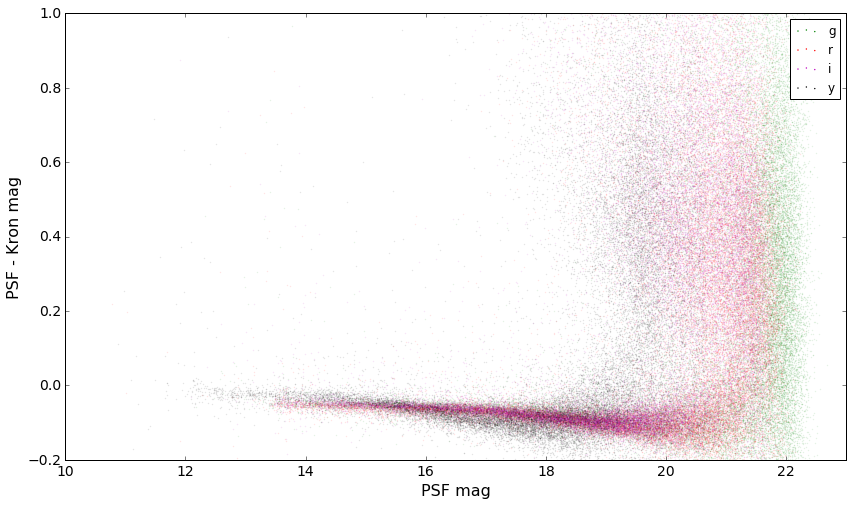

In [6]:
psfmkron = {}
for band in bands:
    psfnm = 'mo_{}MeanPSFMag'.format(band)
    kronnm = 'mo_{}MeanKronMag'.format(band)
    apnm = 'mo_{}MeanApMag'.format(band)
    
    psfmkron[band] = tab[psfnm] - tab[kronnm]
    
    plt.scatter(tab[psfnm], psfmkron[band], c=btoc[band], label=band, lw=0, alpha=.1,s=2)
    
leg_tree(plt.legend(loc=0))
plt.xlim(10, 23)
plt.ylim(-.2, 1)
plt.xlabel('PSF mag')
plt.ylabel('PSF - Kron mag')

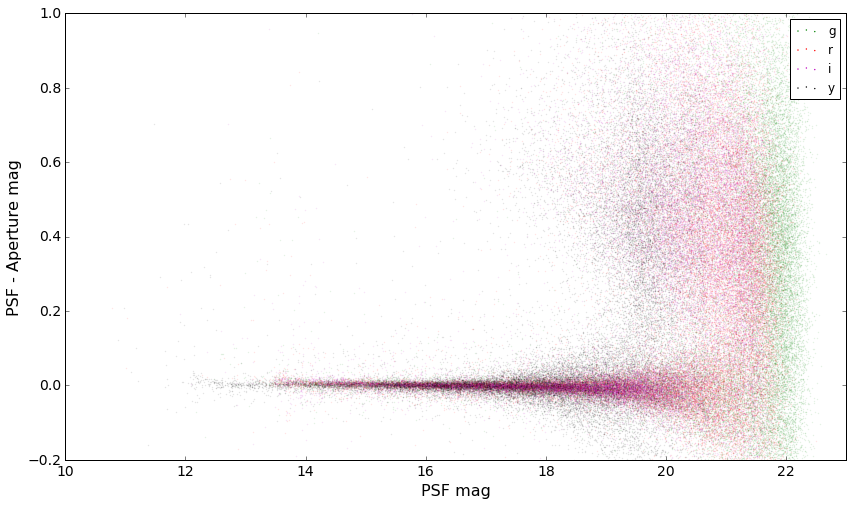

In [7]:
psfmap = {}
for band in bands:
    psfnm = 'mo_{}MeanPSFMag'.format(band)
    kronnm = 'mo_{}MeanKronMag'.format(band)
    apnm = 'mo_{}MeanApMag'.format(band)
    
    psfmap[band] = tab[psfnm] - tab[apnm]
    
    plt.scatter(tab[psfnm], psfmap[band], c=btoc[band], label=band, lw=0, alpha=.1,s=2)
    
leg_tree(plt.legend(loc=0))

plt.xlim(10, 23)
plt.ylim(-.2, 1)
plt.xlabel('PSF mag')
plt.ylabel('PSF - Aperture mag')

# subselect and  format for http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx

## Aperture 

In [8]:
magtype = 'ap'
psfmmag = psfmap

subtab = tab['mo_raMean', 'mo_decMean']
subtab['mo_raMean'].name = 'ra'
subtab['mo_decMean'].name = 'dec'

galmsk = np.zeros(len(subtab), dtype=bool)
for band in bands:
    subtab['psfm{}_{}'.format(magtype, band)] = psfmmag[band]
    galmsk = galmsk | (psfmmag[band] > .2)

name = [(str('gal' if b else 'star') +'_' + magtype + str(i)) for i,b in enumerate(galmsk)]
subtab.add_column(table.Column(name='name', data=name), 0)

subtabgal = subtab[galmsk]
subtabstar = subtab[~galmsk]

In [9]:
sample = np.random.permutation(len(subtabstar))[:25]
subtabstar['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabstar[sample]

name ra dec
star_ap22488 18.53588037 25.52542967
star_ap1404 16.79820722 24.15581211
star_ap16220 17.14180101 25.30854372
star_ap30520 17.68088405 25.92016461
star_ap12203 18.27738832 24.79004492
star_ap8261 17.16771298 24.58790789
star_ap29624 17.32279158 25.71912377
star_ap9322 16.91966016 24.68096491
star_ap19799 18.41223757 25.33068206
star_ap4844 17.18259658 24.38822063
star_ap17598 17.98820446 25.22169548
star_ap15735 16.64520066 25.10174191
star_ap821 18.23460651 24.09207658
star_ap11192 17.84059301 24.99605017
star_ap14223 17.32184852 25.01287727
star_ap5596 16.77478139 24.71398797
star_ap30124 17.28440532 25.6223746
star_ap1446 18.07081044 24.14021088
star_ap16670 18.04144261 25.31480755
star_ap15870 16.88358586 25.07370911
star_ap15300 17.9582473 25.2432272
star_ap30618 17.75896965 25.92717487
star_ap11175 17.26098281 24.93498383
star_ap12796 18.48589101 24.86550473
star_ap28001 17.35582827 25.76950646


name,ra,dec,psfmap_g,psfmap_r,psfmap_i,psfmap_y
str12,float64,float64,float32,float32,float32,float32
star_ap22488,18.53588037,25.52542967,-0.000900269,-0.00440025,0.0145988,-0.011301
star_ap1404,16.79820722,24.15581211,-0.1203,-0.0723,0.0,0.0
star_ap16220,17.14180101,25.30854372,-0.00320053,-0.0135002,-0.00889969,-0.0324993
star_ap30520,17.68088405,25.92016461,0.00669861,-0.0125999,-0.0196991,0.0
star_ap12203,18.27738832,24.79004492,-0.00370026,-0.00479889,0.0067997,-0.0247993
star_ap8261,17.16771298,24.58790789,0.00690079,0.0114994,-0.00119972,0.00289917
star_ap29624,17.32279158,25.71912377,0.00469971,-0.00119972,-0.00219917,0.0547009
star_ap9322,16.91966016,24.68096491,-0.0304012,0.0200005,0.0636005,0.0972996
star_ap19799,18.41223757,25.33068206,0.0196991,-0.00969887,-0.0286007,-0.5923


In [10]:
sample = np.random.permutation(len(subtabgal))[:25]
subtabgal['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabgal[sample]

name ra dec
gal_ap13330 17.23058499 24.98910787
gal_ap5647 18.10968377 24.42562956
gal_ap15910 17.51023169 25.06659901
gal_ap10996 17.38750622 24.78968398
gal_ap22922 16.90854671 25.45291002
gal_ap11675 18.62555061 24.91695316
gal_ap26902 16.71676258 25.73556485
gal_ap26936 17.8137222 25.97274383
gal_ap12705 17.89054535 24.99632092
gal_ap25825 18.33907074 26.01536727
gal_ap1166 18.55515232 24.1161504
gal_ap9542 17.62583691 24.69537456
gal_ap15205 17.63819335 25.17450668
gal_ap27980 17.00531653 25.77370166
gal_ap4369 18.33621817 24.34343773
gal_ap26928 17.55712911 25.97233532
gal_ap5955 17.97150317 24.43568345
gal_ap23988 17.2568408 25.44879583
gal_ap27654 17.6370742 25.73585802
gal_ap25229 18.24566824 25.83575062
gal_ap7181 18.07613962 24.53807377
gal_ap11941 17.8305567 24.99664031
gal_ap7758 17.33876692 24.58471986
gal_ap2537 17.84076541 24.20307207
gal_ap23277 16.92759984 25.64800581


name,ra,dec,psfmap_g,psfmap_r,psfmap_i,psfmap_y
str12,float64,float64,float32,float32,float32,float32
gal_ap13330,17.23058499,24.98910787,0.346001,0.395901,0.5362,0.0
gal_ap5647,18.10968377,24.42562956,0.6113,0.5819,0.715801,0.0
gal_ap15910,17.51023169,25.06659901,0.992102,0.8601,0.834,0.8109
gal_ap10996,17.38750622,24.78968398,0.709,0.6308,0.867901,0.0
gal_ap22922,16.90854671,25.45291002,0.530201,0.528999,0.5811,0.5488
gal_ap11675,18.62555061,24.91695316,0.6621,0.455101,0.4785,0.0
gal_ap26902,16.71676258,25.73556485,0.7658,0.6646,0.8384,0.0
gal_ap26936,17.8137222,25.97274383,0.288502,0.3141,0.3188,0.0
gal_ap12705,17.89054535,24.99632092,0.2006,0.361099,0.3617,0.0


## Kron 

In [11]:
magtype = 'kron'
psfmmag = psfmkron

subtab = tab['mo_raMean', 'mo_decMean']
subtab['mo_raMean'].name = 'ra'
subtab['mo_decMean'].name = 'dec'

galmsk = np.zeros(len(subtab), dtype=bool)
for band in bands:
    subtab['psfm{}_{}'.format(magtype, band)] = psfmmag[band]
    galmsk = galmsk | (psfmmag[band] > .2)

name = [(str('gal' if b else 'star') +'_' + magtype + str(i)) for i,b in enumerate(galmsk)]
subtab.add_column(table.Column(name='name', data=name), 0)

subtabgal = subtab[galmsk]
subtabstar = subtab[~galmsk]

In [12]:
sample = np.random.permutation(len(subtabstar))[:25]
subtabstar['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabstar[sample]

name ra dec
star_kron23852 18.35578711 25.67580446
star_kron24790 18.48296917 25.4590041
star_kron23198 17.61186995 25.43733875
star_kron2160 16.96973129 24.1989225
star_kron7597 16.85016646 24.58218169
star_kron27430 17.27016894 25.81832982
star_kron4072 18.00939958 24.31355453
star_kron1871 16.78754696 24.17172329
star_kron24833 17.07994887 25.72776852
star_kron14588 17.63779376 25.02237975
star_kron6119 17.61957914 24.45824838
star_kron2822 16.65717011 24.2306013
star_kron16290 17.80955578 25.03199943
star_kron607 16.75077482 24.08247674
star_kron5351 16.82125236 24.41084236
star_kron26770 18.61711367 25.95093253
star_kron18756 17.36752975 25.52907122
star_kron3118 18.23593438 24.24702042
star_kron17219 16.89634072 25.31951879
star_kron28050 18.36524614 25.76750579
star_kron19266 17.29462976 25.1888995
star_kron9714 16.86581377 24.67332964
star_kron5796 18.03084733 24.42247437
star_kron28519 18.39303548 25.47605772
star_kron5476 17.95910831 24.3929395


name,ra,dec,psfmkron_g,psfmkron_r,psfmkron_i,psfmkron_y
str14,float64,float64,float32,float32,float32,float32
star_kron23852,18.35578711,25.67580446,-0.0697002,-0.0564995,-0.0526009,-0.0528002
star_kron24790,18.48296917,25.4590041,-0.111502,-0.0963001,-0.0950012,-0.1341
star_kron23198,17.61186995,25.43733875,-0.016901,0.0846996,-0.0647011,0.0699005
star_kron2160,16.96973129,24.1989225,0.115499,-0.128399,-0.1224,-0.0911999
star_kron7597,16.85016646,24.58218169,-0.0890007,-0.106699,-0.0763016,-0.1201
star_kron27430,17.27016894,25.81832982,-0.142599,-0.1341,-0.1378,-0.1702
star_kron4072,18.00939958,24.31355453,-0.0823002,-0.0496998,-0.0246,-0.0293999
star_kron1871,16.78754696,24.17172329,-0.0597,-0.0740013,-0.1042,-0.119801
star_kron24833,17.07994887,25.72776852,0.0907001,-0.0587997,-0.0433998,0.0


In [13]:
sample = np.random.permutation(len(subtabgal))[:25]
subtabgal['name', 'ra', 'dec'][sample].write(None, format='ascii')
subtabgal[sample]

name ra dec
gal_kron21944 17.82933962 25.51096646
gal_kron10289 18.5434683 24.71643655
gal_kron7535 18.03923531 24.54861532
gal_kron11186 18.173207 24.96193482
gal_kron4410 17.26065002 24.36572735
gal_kron5498 18.5750409 24.40831759
gal_kron3268 17.90214987 24.25145325
gal_kron18593 17.57277047 25.12162215
gal_kron12803 17.18535949 24.94938219
gal_kron27568 17.68698514 25.83207089
gal_kron17985 16.75900251 25.08077113
gal_kron21349 17.2926434 25.52072215
gal_kron15985 17.14906485 25.27690325
gal_kron465 16.74056574 24.05307261
gal_kron7066 18.08749455 24.53985843
gal_kron67 17.63566911 24.13969262
gal_kron23593 18.17997577 25.71072214
gal_kron7883 18.37628328 24.56241307
gal_kron23716 17.27858003 25.54205956
gal_kron20814 18.27861582 25.05261319
gal_kron22756 18.10083371 25.70602362
gal_kron7160 18.29776676 24.52250055
gal_kron4913 17.6207957 24.37099833
gal_kron3185 16.77829733 24.25292297
gal_kron8146 17.23953408 24.60233623


name,ra,dec,psfmkron_g,psfmkron_r,psfmkron_i,psfmkron_y
str14,float64,float64,float32,float32,float32,float32
gal_kron21944,17.82933962,25.51096646,1.2345,1.1762,1.2706,1.4855
gal_kron10289,18.5434683,24.71643655,0.373699,0.396502,0.5741,0.4902
gal_kron7535,18.03923531,24.54861532,0.6693,0.680599,0.7216,0.648399
gal_kron11186,18.173207,24.96193482,1021.94,0.2609,0.3286,0.4641
gal_kron4410,17.26065002,24.36572735,0.967501,0.830799,0.8258,0.965099
gal_kron5498,18.5750409,24.40831759,0.0732002,0.3335,0.455601,0.0
gal_kron3268,17.90214987,24.25145325,0.2638,-0.00860023,-0.0965004,0.0727997
gal_kron18593,17.57277047,25.12162215,0.037199,0.2258,0.387501,0.377701
gal_kron12803,17.18535949,24.94938219,0.2286,0.1007,0.279701,0.358801


# Stacked 

In [14]:
stab = Table.read('stack_vdev0jegpeek.fits.gz')
stab

st_raStack,st_decStack,st_gPSFMag,st_rPSFMag,st_iPSFMag
float64,float64,float32,float32,float32
16.64952084,24.0605159,22.7063,21.827,21.7515
17.64181533,24.06587367,22.2649,21.0322,20.7627
18.07518563,24.05819622,18.3893,17.2146,16.3649
18.10100268,24.06197371,-999.0,22.4416,21.6256
18.10847785,24.05901398,-999.0,24.6451,23.087
18.11416103,24.06195597,21.6039,20.2363,19.1633
18.12148931,24.06621561,-999.0,23.3526,22.6676
18.12532742,24.05968125,-999.0,24.1638,24.0591
18.12939736,24.06339085,-999.0,22.4502,-999.0


In [15]:
gmi_stack = stab['st_gPSFMag'] - stab['st_iPSFMag']
r_stack = stab['st_rPSFMag']

gmi_nstack = tab['mo_gMeanPSFMag'] - tab['mo_iMeanPSFMag']
r_nstack = tab['mo_rMeanPSFMag']

(23.0, 15)

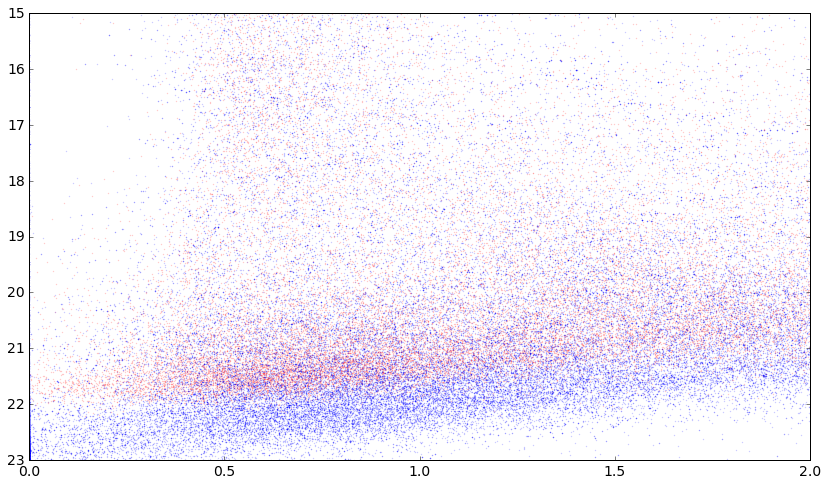

In [16]:
plt.scatter(gmi_nstack, r_nstack, alpha=.2, lw=0, s=2, c='r')
plt.scatter(gmi_stack, r_stack, alpha=.2, lw=0, s=2, c='b')

plt.xlim(0, 2)
plt.ylim(23., 15)

# Draco field 

In [17]:
dmean = Table.read('draco_mean_db_jegpeek.fits.gz')
dmean

o_nDetections,o_raMean,o_decMean,m_gMeanApMagErr,m_iMeanKronMagErr,m_rMeanApMag,m_zMeanKronMag,m_rMeanApMagErr,m_zMeanKronMagErr,m_gMeanPSFMag,m_iMeanApMag,m_yMeanKronMag,m_gMeanPSFMagErr,m_iMeanApMagErr,m_yMeanKronMagErr,m_rMeanPSFMag,m_zMeanApMag,m_rMeanPSFMagErr,m_zMeanApMagErr,m_iMeanPSFMag,m_yMeanApMag,m_iMeanPSFMagErr,m_yMeanApMagErr,m_gMeanKronMag,m_zMeanPSFMag,m_gMeanKronMagErr,m_zMeanPSFMagErr,m_rMeanKronMag,m_yMeanPSFMag,m_rMeanKronMagErr,m_yMeanPSFMagErr,m_gMeanApMag,m_iMeanKronMag
int16,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32
1,259.0559176,57.41566553,0.31653,-999.0,-999.0,-999.0,-999.0,-999.0,22.1729,-999.0,-999.0,0.31653,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.2564,-999.0
1,259.1880543,57.41912636,-999.0,-999.0,-999.0,18.3729,-999.0,0.04886,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,18.2163,-999.0,0.024999,-999.0,-999.0,-999.0,-999.0,-999.0,17.9725,-999.0,0.024999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19006746,57.41931863,-999.0,-999.0,-999.0,17.7582,-999.0,0.042779,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.715,-999.0,0.022879,-999.0,-999.0,-999.0,-999.0,-999.0,17.8657,-999.0,0.022879,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
0,259.19047641,57.41699938,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19101419,57.42112874,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,21.1113,-999.0,0.417797,-999.0,-999.0
1,259.19120521,57.42276479,0.19161,-999.0,-999.0,-999.0,-999.0,-999.0,21.9958,-999.0,-999.0,0.19161,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.9747,-999.0
1,259.19123998,57.41744054,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,16.7785,-999.0,-999.0,0.018919,-999.0,-999.0,-999.0,-999.0,-999.0,16.67,-999.0,0.010186,-999.0,-999.0,-999.0,-999.0,-999.0,16.3275,-999.0,0.010186,-999.0,-999.0
1,259.19363074,57.41962882,-999.0,-999.0,-999.0,17.3036,-999.0,0.020172,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.6957,-999.0,0.010116,-999.0,-999.0,-999.0,-999.0,-999.0,16.8285,-999.0,0.010116,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,259.19458297,57.41981379,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,17.4912,-999.0,0.0089,-999.0,-999.0,-999.0,-999.0,-999.0,16.6297,-999.0,0.0089,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [18]:
dstack = Table.read('stack_draco_jegpeek.fits.gz')
dstack

st_raStack,st_decStack,st_gPSFMag,st_rPSFMag,st_iPSFMag,st_zPSFMag,st_yPSFMag,st_gPSFMagErr,st_rPSFMagErr,st_iPSFMagErr,st_zPSFMagErr,st_yPSFMagErr,st_gApMag,st_rApMag,st_iApMag,st_zApMag,st_yApMag,st_gApMagErr,st_rApMagErr,st_iApMagErr,st_zApMagErr,st_yApMagErr,st_gKronMag,st_rKronMag,st_iKronMag,st_zKronMag,st_yKronMag,st_gKronMagErr,st_rKronMagErr,st_iKronMagErr,st_zKronMagErr,st_yKronMagErr
float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
260.0033729,57.4275286,21.5865,20.2532,19.4242,19.1342,18.6692,0.042282,0.013842,0.006821,0.015663,0.020224,21.622,20.2782,19.4327,19.0694,18.6553,0.009353,0.004113,0.001957,0.002784,0.002139,21.7861,20.3854,19.5352,19.1681,18.8004,0.067161,0.020355,0.01148,0.024776,0.033934
260.01647512,57.42470151,16.6737,15.8944,-999.0,15.786,-999.0,0.006143,0.013045,-999.0,0.005005,0.185692,16.1989,16.6332,-999.0,14.9063,15.8719,0.00077,0.000768,-999.0,0.000409,0.000594,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,16.6737,15.8944,-999.0,15.786,-999.0,0.006143,0.013045,-999.0,0.005005,0.185692,16.1989,16.6332,-999.0,14.9063,15.8719,0.00077,0.000768,-999.0,0.000409,0.000594,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,-999.0,-999.0,15.1588,-999.0,18.5772,-999.0,-999.0,0.001573,-999.0,0.074033,-999.0,-999.0,15.9183,-999.0,15.9618,-999.0,-999.0,0.000388,-999.0,0.000619,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.01647512,57.42470151,-999.0,-999.0,15.1588,-999.0,18.5772,-999.0,-999.0,0.001573,-999.0,0.074033,-999.0,-999.0,15.9183,-999.0,15.9618,-999.0,-999.0,0.000388,-999.0,0.000619,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
260.02275962,57.43262296,-999.0,-999.0,-999.0,25.8609,21.2717,0.486614,0.413184,2.3412,5.44683,0.198775,-999.0,-999.0,-999.0,25.3049,21.2487,0.025094,0.016984,0.015228,0.049182,0.00706,-999.0,-999.0,-999.0,-999.0,21.002,-999.0,-999.0,-999.0,-999.0,0.288497
260.04166095,57.42984656,-999.0,25.1893,22.9765,26.8419,22.0758,1.6881,1.20742,0.163842,12.8607,0.459186,24.2684,-999.0,23.525,-999.0,22.6381,0.03164,0.025884,0.012883,0.021841,0.013387,-999.0,-999.0,23.3208,-999.0,-999.0,-999.0,-999.0,0.299629,-999.0,-999.0
260.05339703,57.42819067,22.7774,21.6236,20.956,20.6425,20.2708,0.097722,0.045791,0.025751,0.043203,0.081305,22.041,21.1735,20.3401,20.0239,19.5465,0.011344,0.006211,0.002972,0.004321,0.003224,22.0597,21.0261,20.2658,20.0392,19.4981,0.106365,0.052522,0.027109,0.047862,0.081551
260.0723225,57.42908103,23.4046,25.2127,-999.0,-999.0,22.1166,0.180236,1.10416,0.337676,1.1329,0.492831,24.9435,-999.0,-999.0,-999.0,21.648,0.043178,0.01807,0.010564,0.031149,0.008485,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


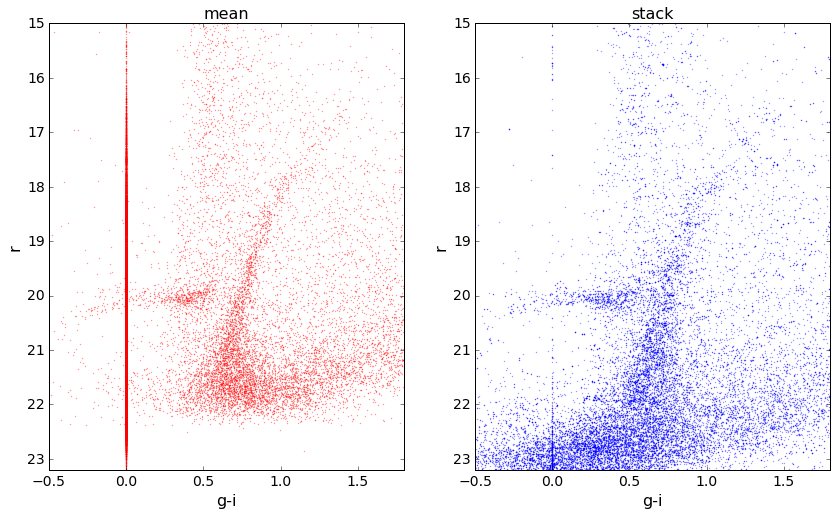

In [30]:
gmi_stack = dstack['st_gPSFMag'] - dstack['st_iPSFMag']
r_stack = dstack['st_rPSFMag']

gmi_mean = dmean['m_gMeanPSFMag'] - dmean['m_iMeanPSFMag']
r_mean = dmean['m_rMeanPSFMag']

fig, axs = plt.subplots(1, 2)
axs[0].scatter(gmi_mean, r_mean, alpha=.4, lw=0, s=2, c='r')
axs[1].scatter(gmi_stack, r_stack, alpha=.4, lw=0, s=2, c='b')

for ax in axs:
    ax.set_xlim(-.5, 1.8)
    ax.set_ylim(23.2, 15)
    
    ax.set_xlabel('g-i')
    ax.set_ylabel('r')
    
axs[0].set_title('mean')
axs[1].set_title('stack')